In [65]:
import time
import warnings
import numpy as np
from numpy.random import choice, dirichlet, randint, normal, rand
from numpy.linalg import eig, svd, qr, norm
from scipy.stats import entropy
from scipy.linalg import pinv
from scipy.spatial.distance import cdist, euclidean, pdist, squareform
from scipy.interpolate import interpn, LinearNDInterpolator, RBFInterpolator
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import normalize
from tensorflow.keras.datasets import mnist

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import tensorly as tl
from tensorly.decomposition import power_iteration, parafac_power_iteration

def SketchyCoreSVD(A,r,m,n):
    sampled_row = choice(A.shape[0],m,replace=False)
    sampled_col = choice(A.shape[1],n,replace=False)
    
    km = int(r + (m-r)/3)
    sm = int(r + 2*(m-r)/3)
    kn = int(r + (n-r)/3)
    sn = int(r + 2*(n-r)/3)

    Map = normal(size=(km,m))
    Map_T = normal(size=(n,kn))
    MapL = normal(size=(sm,m))
    MapR = normal(size=(sn,n))

    X = Map @ A[list(sampled_row),:]
    Y = A[:,list(sampled_col)] @ Map_T
    Z = MapL @ A[np.meshgrid(list(sampled_row), list(sampled_col), indexing='ij')[0],np.meshgrid(list(sampled_row), list(sampled_col), indexing='ij')[1]] @ MapR.T

    P, R1 = qr(np.array(X.T))
    Q, R2 = qr(np.array(Y))

    C = pinv(MapL @ Q[list(sampled_row),:]).dot(Z).dot(pinv(MapR @ P[list(sampled_col),:]).T)
    Ahat = Q.dot(C).dot(P.T)
    return norm(A - Ahat)**2 / norm(A)**2

def SVD_rank(A):
    # matrix unfoldings
    A1 = A
    A2 = A.T
    
    U1, s1, V1 = svd(A1,full_matrices=False)
    U2, s2, V2 = svd(A2,full_matrices=False)
    
    scree1 = []
    scree2 = []
    for r in range(s1.shape[0]):
        print(r,end='\r')
        scree1.append(norm(s1[r+1:])**2 / norm(A1)**2)
        if norm(s1[r+1:])**2 / norm(A1)**2 < 1e-7 :
                break
    for r in range(s2.shape[0]):
        print(r,end='\r')
        scree2.append(norm(s2[r+1:])**2 / norm(A2)**2)
        if norm(s2[r+1:])**2 / norm(A2)**2 < 1e-7 :
                break
                
    return [scree1, scree2]

def similarity_func(u, v):
    return 1/(1+euclidean(u,v))

# load MNIST dataset

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
A = X_train[:1000].reshape(1000,28*28) / 255.
N = A.shape

In [4]:
N

(1000, 784)

In [119]:
scree = SVD_rank(A)

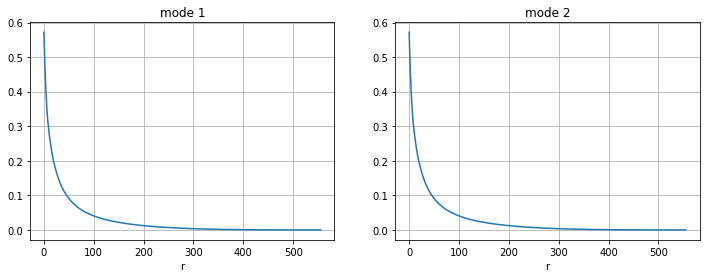

In [286]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(scree[0])
ax[0].set_title('mode 1')
ax[0].set_xlabel('r')
ax[0].grid()

ax[1].plot(scree[1])
ax[1].set_title('mode 2')
ax[1].set_xlabel('r')
ax[1].grid()
plt.show()

In [120]:
U,S,Vh = svd(A,full_matrices=False)

In [121]:
Ahat = np.dot(U[:, :100] * S[:100], Vh[:100,:])

In [122]:
norm(A - Ahat)**2 / norm(A)**2

0.04263357443519009

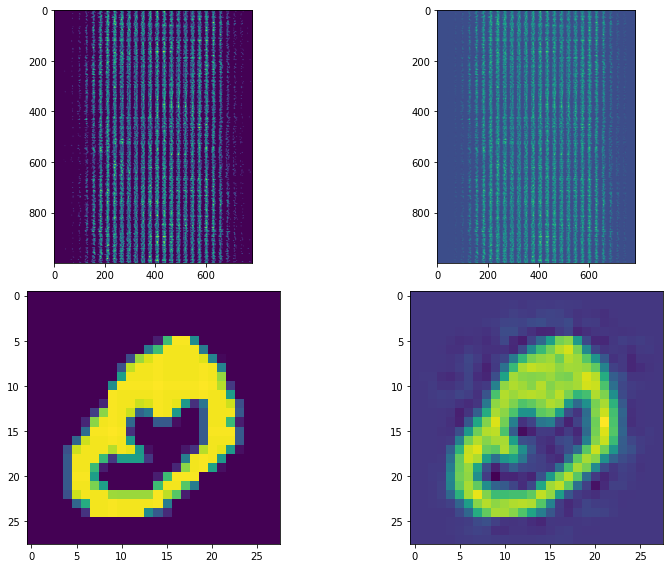

In [123]:
fig, ax = plt.subplots(2,2,figsize=[12,8])
ax[0,0].imshow(A)
ax[0,1].imshow(Ahat)
ax[1,0].imshow(A[63].reshape(28,28))
ax[1,1].imshow(Ahat[63].reshape(28,28))
plt.tight_layout()
plt.show()

# ProgressiveSketchingSpectralClustering

In [108]:
%%time
k = [20,6]
b = 100
r = 100

num_of_iter = 10

samplenum_log = []
Ahat_log = []
err_log = []
rnd_Ahat_log = []
rnd_err_log = []

for _ in range(20):
    sampled_row = set()
    unsampled_row = set(np.arange(N[0]))
    sampled_col = set()
    unsampled_col = set(np.arange(N[1]))
    memberships_row = choice(range(k[0]),N[0])
    memberships_col = choice(range(k[1]),N[1])
    delta_row = np.full((k[0],),int(b/np.sum(k)))
    delta_col = np.full((k[1],),int(b/np.sum(k)))

    for iter_index in range(1,num_of_iter):
        # sample new rows
        add_row = []
        for i in range(k[0]):
            if (len(np.where(memberships_row[sorted(unsampled_row)] == i)[0]) != 0) & (delta_row[i] > 0):
                if len(np.where(memberships_row[sorted(unsampled_row)] == i)[0]) <= delta_row[i]:
                    add_row.append(np.array(sorted(unsampled_row))[np.where(memberships_row[sorted(unsampled_row)] == i)[0]])
                else:
                    add_row.append(choice(np.array(sorted(unsampled_row))[np.where(memberships_row[sorted(unsampled_row)] == i)[0]],delta_row[i],replace=False)) 
        if len(add_row) > 0 :
            new_row = np.concatenate(add_row)
            sampled_row.update(new_row)
            unsampled_row = unsampled_row - set(new_row)
        samples_row = A[sorted(sampled_row)]

        # sample new cols
        add_col = []
        for i in range(k[1]):
            if (len(np.where(memberships_col[sorted(unsampled_col)] == i)[0]) != 0) & (delta_col[i] > 0):
                if len(np.where(memberships_col[sorted(unsampled_col)] == i)[0]) <= delta_col[i]:
                       add_col.append(np.array(sorted(unsampled_col))[np.where(memberships_col[sorted(unsampled_col)] == i)[0]])
                else:
                       add_col.append(choice(np.array(sorted(unsampled_col))[np.where(memberships_col[sorted(unsampled_col)] == i)[0]],delta_col[i],replace=False))
        if len(add_col) > 0:
            new_col = np.concatenate(add_col)
            sampled_col.update(new_col)
            unsampled_col = unsampled_col - set(new_col)
        samples_col = A.T[sorted(sampled_col)]

        # Row Spectral Clustering
        submemberships_row = np.argmin(cdist(samples_col.T,samples_col[:,sorted(sampled_row)].T),axis=1)
        W_row = squareform(pdist(samples_col[:,sorted(sampled_row)].T,similarity_func))
        D_row = np.diag(np.sum(W_row,axis=1))
        L_row = D_row - W_row
        eigval_row, eigvec_row = eig(L_row)
        V_row = np.real(eigvec_row[:,np.argsort(eigval_row)[-1:-1-k[0]:-1]])
        kmeans_row = KMeans(n_clusters=k[0]).fit(V_row)
        memberships_dict_row = dict(enumerate(kmeans_row.labels_))
        memberships_row = np.array([memberships_dict_row[i] for i in submemberships_row])
        
        # Col Spectral Clustering
        submemberships_col = np.argmin(cdist(samples_row.T,samples_row[:,sorted(sampled_col)].T),axis=1)
        W_col = squareform(pdist(samples_row[:,sorted(sampled_col)].T,similarity_func))
        D_col = np.diag(np.sum(W_col,axis=1))
        L_col = D_col - W_col
        eigval_col, eigvec_col= eig(L_col)
        V_col = np.real(eigvec_col[:,np.argsort(eigval_col)[-1:-1-k[1]:-1]])
        kmeans_col = KMeans(n_clusters=k[1]).fit(V_col)
        memberships_dict_col = dict(enumerate(kmeans_col.labels_))
        memberships_col = np.array([memberships_dict_col[i] for i in submemberships_col])

        #variation calculation
        var_row = np.var(samples_col,axis=0)
        var_col = np.var(samples_row,axis=0)
        entropy_sad_row = []
        entropy_sad_col = []
        for i in range(k[0]):
            if np.sum(memberships_row == i) > 1 and np.sum(var_row[memberships_row == i]) > 0:
                entropy_sad_row.append(entropy(var_row[memberships_row == i]))
            else:
                entropy_sad_row.append(0.001)
        for i in range(k[1]):
            if np.sum(memberships_col == i) > 1 and np.sum(var_col[memberships_col == i]) > 0:
                entropy_sad_col.append(entropy(var_col[memberships_col == i]))
            else:
                entropy_sad_col.append(0.001)   
        entropy_sad_row = np.array(entropy_sad_row)
        entropy_sad_col = np.array(entropy_sad_col)
        entropy_sad_row[np.where(entropy_sad_row == 0)] = 0.001
        entropy_sad_col[np.where(entropy_sad_col == 0)] = 0.001

        delta = np.array(dirichlet(np.append(entropy_sad_row,entropy_sad_col),1)[0] * b,dtype=int)
        delta_row = delta[:k[0]]
        delta_col = delta[k[0]:]

        #SketchyCoreSVD
        m = len(sampled_row)
        n = len(sampled_col)
        #if min(m,n) > r:
        if iter_index == num_of_iter-1:
            km = int(r + (m-r)/3)
            sm = int(r + 2*(m-r)/3)
            kn = int(r + (n-r)/3)
            sn = int(r + 2*(n-r)/3)

            rnd_sampled_row = choice(N[0],m,replace=False)
            rnd_sampled_col = choice(N[1],n,replace=False)

            Map = normal(size=(km,m))
            Map_T = normal(size=(n,kn))
            MapL = normal(size=(sm,m))
            MapR = normal(size=(sn,n))

            X = Map @ A[sorted(sampled_row),:]
            Y = A[:,sorted(sampled_col)] @ Map_T
            Z = MapL @ A[np.meshgrid(sorted(sampled_row), sorted(sampled_col), indexing='ij')[0],np.meshgrid(sorted(sampled_row), sorted(sampled_col), indexing='ij')[1]] @ MapR.T
            P, R1 = qr(np.array(X.T))
            Q, R2 = qr(np.array(Y))
            C = pinv(MapL @ Q[sorted(sampled_row),:]).dot(Z).dot(pinv(MapR @ P[sorted(sampled_col),:]).T)
            Ahat = Q.dot(C).dot(P.T)

            Ahat_log.append(Ahat[63])
            err_log.append(norm(A - Ahat)**2 / norm(A)**2)
            samplenum_log.append([m,n])

            X = Map @ A[sorted(rnd_sampled_row),:]
            Y = A[:,sorted(rnd_sampled_col)] @ Map_T
            Z = MapL @ A[np.meshgrid(sorted(rnd_sampled_row), sorted(rnd_sampled_col), indexing='ij')[0],np.meshgrid(sorted(rnd_sampled_row), sorted(rnd_sampled_col), indexing='ij')[1]] @ MapR.T
            P, R1 = qr(np.array(X.T))
            Q, R2 = qr(np.array(Y))
            C = pinv(MapL @ Q[sorted(rnd_sampled_row),:]).dot(Z).dot(pinv(MapR @ P[sorted(rnd_sampled_col),:]).T)
            Ahat = Q.dot(C).dot(P.T)

            rnd_Ahat_log.append(Ahat[63])
            rnd_err_log.append(norm(A - Ahat)**2 / norm(A)**2)
            #print(iter_index, len(sampled_row), len(sampled_col), norm(A - Ahat)**2 / norm(A)**2, norm(A - rnd_Ahat)**2 / norm(A)**2)
        #else:
            #print(iter_index, len(sampled_row), len(sampled_col))

Wall time: 3min 1s


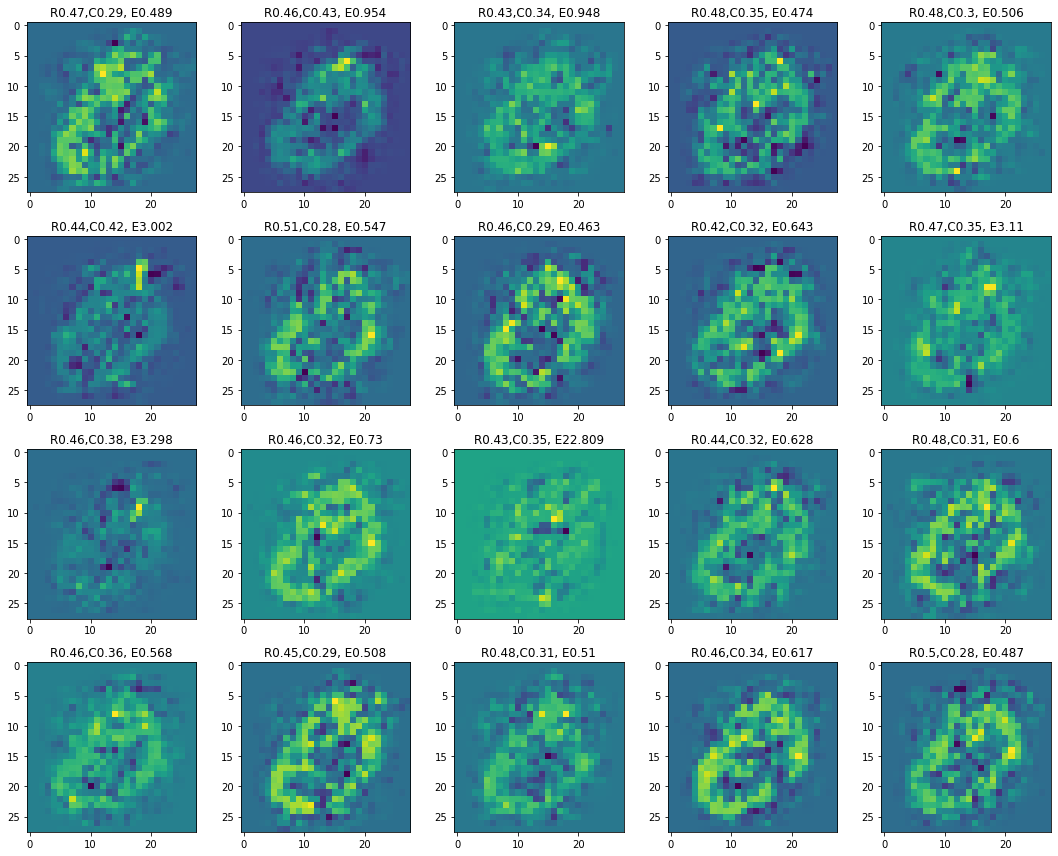

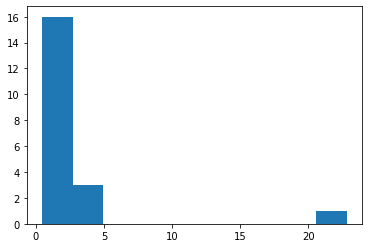

2.0946027667306515


In [109]:
fig, ax = plt.subplots(4,5,figsize=[15,12])
for img, axis, snum, err in zip(Ahat_log,ax.ravel(),samplenum_log,err_log):
    axis.imshow(img.reshape(28,28))
    axis.set_title(f'R{np.round(snum[0]/N[0],2)},C{np.round(snum[1]/N[1],2)}, E{np.round(err,3)}')
plt.tight_layout()
plt.show()

plt.hist(err_log)
plt.show()

print(np.mean(err_log))

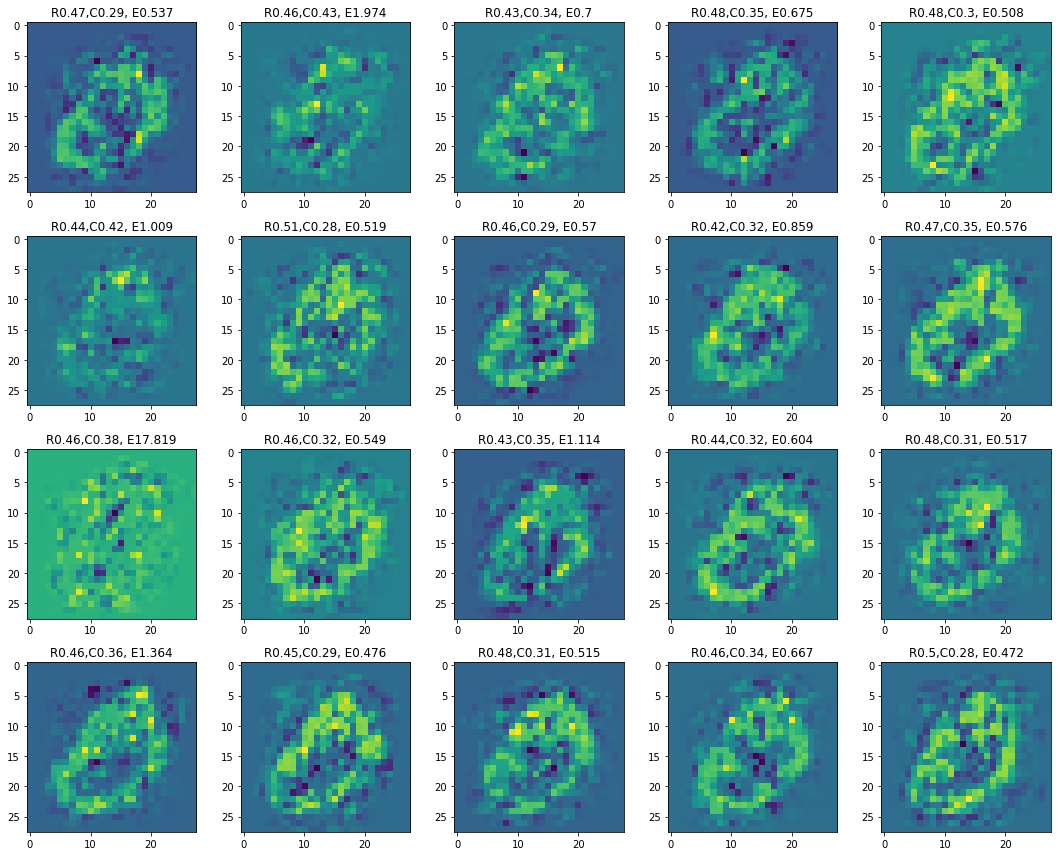

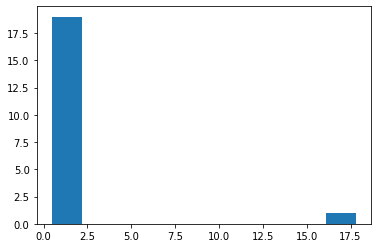

1.6011876616418472


In [110]:
fig, ax = plt.subplots(4,5,figsize=[15,12])
for img, axis, snum, err in zip(rnd_Ahat_log,ax.ravel(),samplenum_log,rnd_err_log):
    axis.imshow(img.reshape(28,28))
    axis.set_title(f'R{np.round(snum[0]/N[0],2)},C{np.round(snum[1]/N[1],2)}, E{np.round(err,3)}')
plt.tight_layout()
plt.show()

plt.hist(rnd_err_log)
plt.show()

print(np.mean(rnd_err_log))